In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits import mplot3d
from scipy.stats import chi2
from scipy.linalg import cholesky
from itertools import combinations, product
from functools import reduce
import warnings

warnings.filterwarnings('ignore')
fig_size = plt.rcParams['figure.figsize']

%matplotlib inline

In [2]:
def nCr(n, r):
    return math.factorial(n) / (math.factorial(n - r) * math.factorial(r))


def sim_chisquare(sts, var_ids):
    return reduce(lambda x, y: x + y, [sts[j] ** 2 for j in var_ids])


@np.vectorize
def normal_pdf(x, mu, sigma):
    part1 = (x - mu) / sigma
    part2 = sigma * np.sqrt(2 * np.pi)
    return np.exp(-(part1 ** 2) / 2) / part2


@np.vectorize
def chisquare_pdf(x, dof):
    kby2 = dof / 2
    part1 = (x ** (kby2 - 1)) * np.exp(-x / 2)
    part2 = math.gamma(kby2) * (2 ** kby2)
    return part1 / part2


@np.vectorize
def t_pdf(x, dof):
    part1 = math.gamma((dof + 1) / 2) * ((1 + ((x ** 2) / dof)) ** (-0.5 * (dof + 1)))
    part2 = np.sqrt(dof * np.pi) * math.gamma(dof / 2)
    return part1 / part2


@np.vectorize
def t_sample(z, u, dof):
    denom = np.sqrt(u / dof)
    return z / denom


@np.vectorize
def f_sample(numerator, nume_dof, denominator, denom_dof):
    return (numerator / nume_dof) / (denominator / denom_dof)


def beta(a, b):
    return math.gamma(a) * math.gamma(b) / math.gamma(a + b)


@np.vectorize
def f_pdf(x, dof1, dof2):
    part11 = ((dof1 * x) ** dof1) * (dof2 ** dof2)
    part12 = (dof1 * x + dof2) ** (dof1 + dof2)
    part1 = np.sqrt(part11 / part12)
    part2 = x * beta(dof1 / 2, dof2 / 2)
    return part1 / part2

In [3]:
# Creating Standard Normal variables to use for Questions 1, 2, 3
NUM_ST = 6
sts = [np.random.normal(loc=0, scale=1, size=1000) for _ in range(NUM_ST)]

# Question 1

### Chi-Squared Distribution
The Chi-squared random variable is defined as the sum of squares of n independent standard normal variables.<br>
$\chi^2_n = \Sigma_{i = 1}^{n}Z_i^2$; where $Z_i$'s are independent standard normal variables.

$\chi^2_n$ is said to have $n$ degrees of freedom.

In [4]:
def plot_chisquares(atatime, sts):
    _Combos = combinations(range(NUM_ST), atatime)
    num_combos = int(nCr(NUM_ST, atatime))
    nrows = math.ceil(num_combos / 2)
    ncols = 2
    fig, ax = plt.subplots(nrows, ncols, figsize=(fig_size[0] * ncols, fig_size[1] * nrows))
    if num_combos % 2:
        ax.flatten()[-1].remove()

    for i, st_s in enumerate(_Combos):
#         chi_square = reduce(lambda x, y: x + y, [sts[j] ** 2 for j in st_s])
        chi_square = sim_chisquare(sts, st_s)
        true_chisquared_in = np.linspace(max(0, min(chi_square) - 0.5), max(chi_square) + 0.5, num=10000)
        _ = sns.kdeplot(chi_square, ax=ax.flatten()[i], label="From SNV")
        _ = sns.kdeplot(np.random.chisquare(df=atatime, size=1000), ax=ax.flatten()[i], label="True Chi Squared")
        _ = sns.lineplot(true_chisquared_in, chisquare_pdf(true_chisquared_in, atatime), ax=ax.flatten()[i], label="True Chi Squared PDF")
        _ = ax.flatten()[i].set_title(", ".join([f"$St_{j + 1}$" for j in st_s]))
    
    plt.tight_layout(3)
    plt.suptitle(f"$\chi^2_{atatime}$")

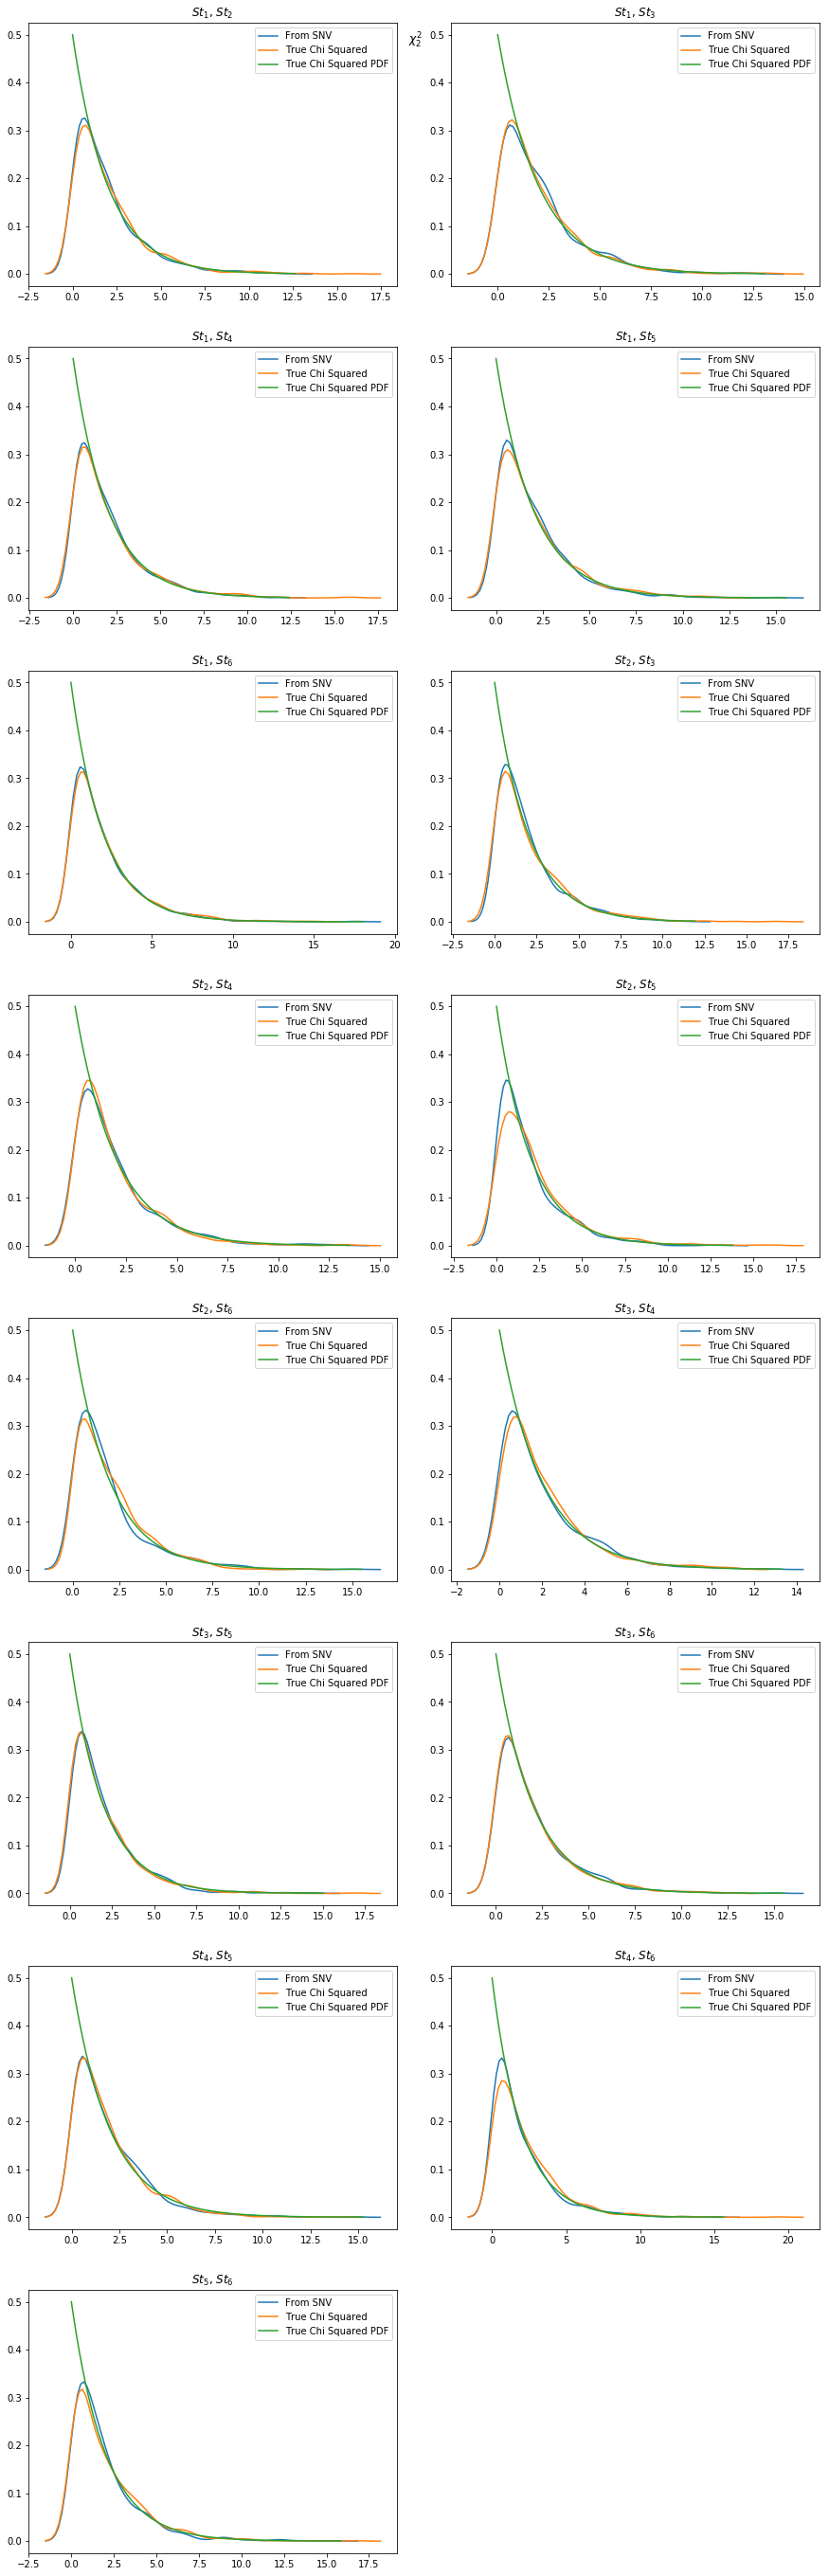

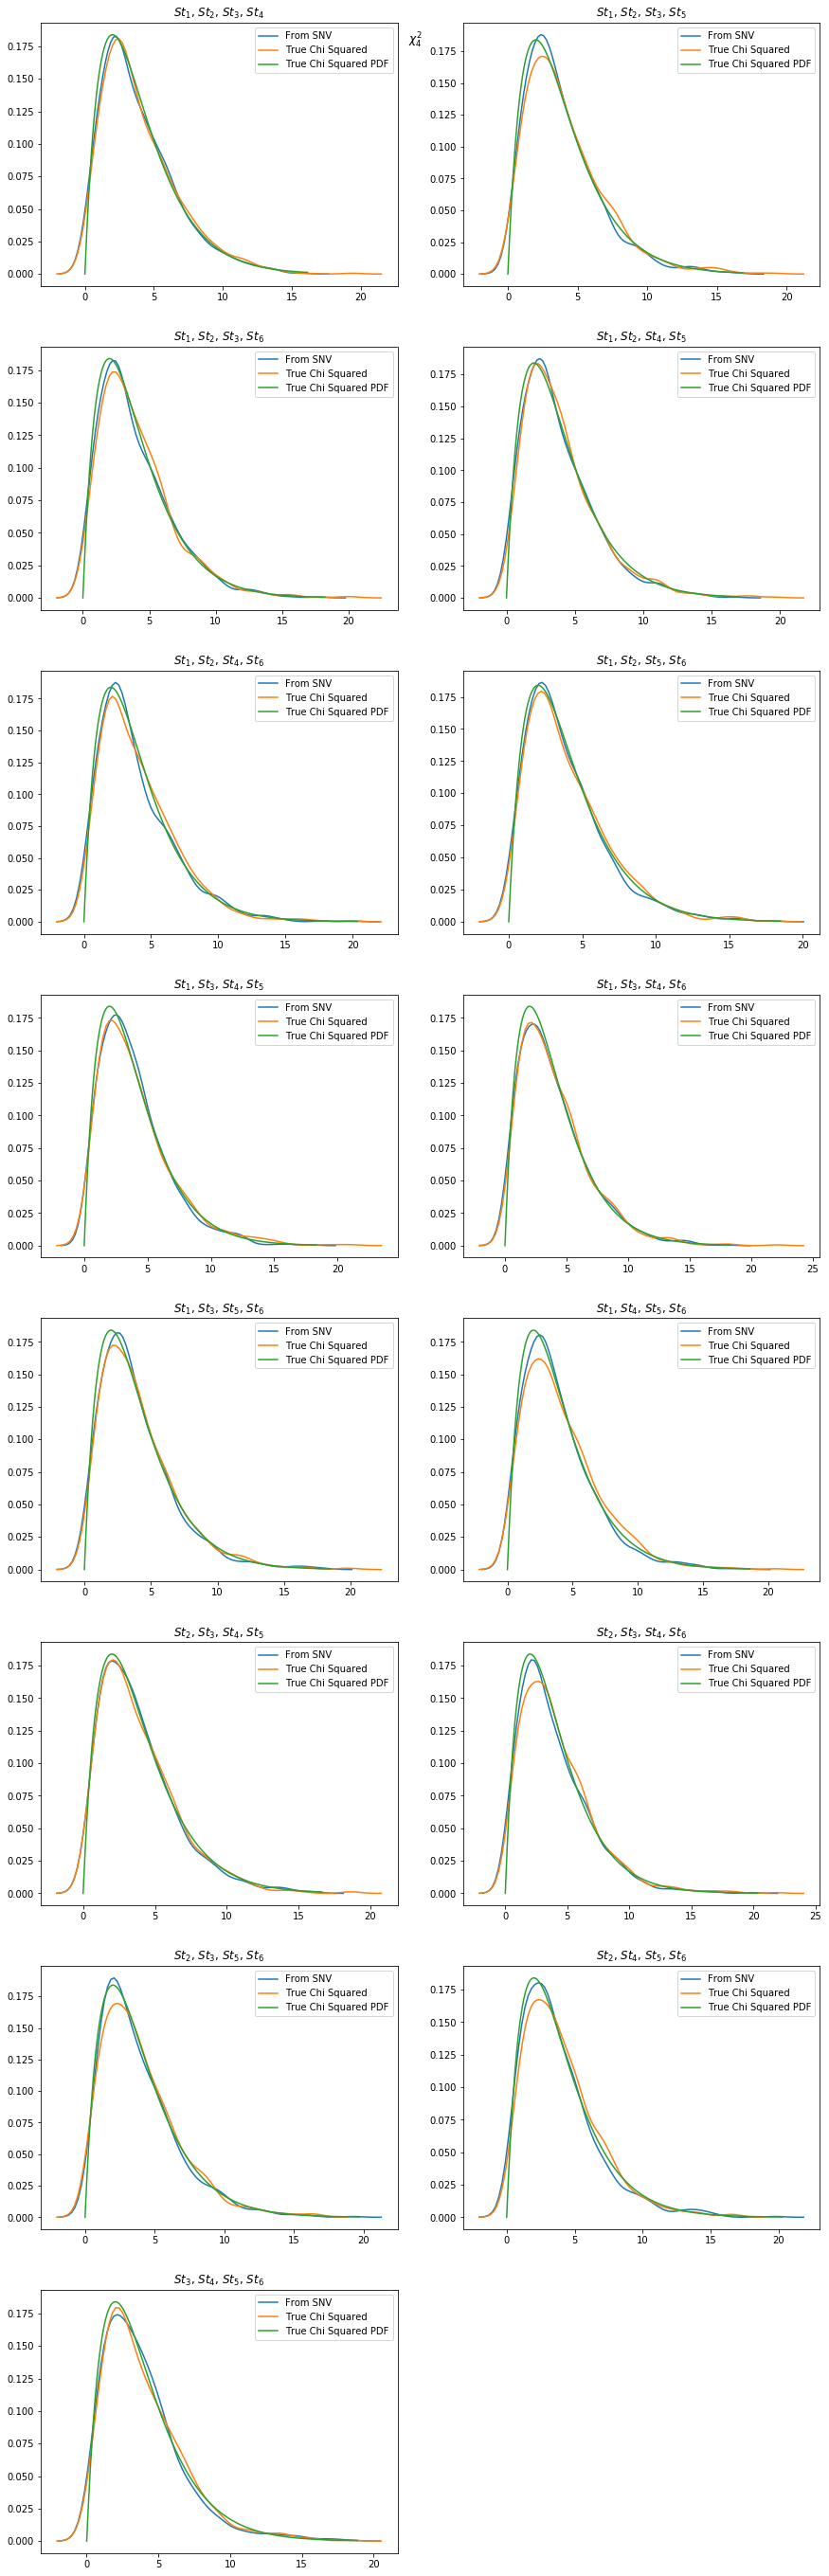

In [5]:
# 2-combos
plot_chisquares(2, sts)

# 4-combos
plot_chisquares(4, sts)

# Question 2

### T Distribution
The T random variable is defined as the ratio of a standard normal variable to the square root of an independent adjusted chi-squared variable.<br><br>
$t_n = \frac{Z}{\sqrt{\frac{U}{n}}}$; where $Z$ is the standard normal variable, $U$ is the chi-squared variable, $n$ is the degrees of freedom of $U$.

$t_n$ is said to have $n$ degrees of freedom.

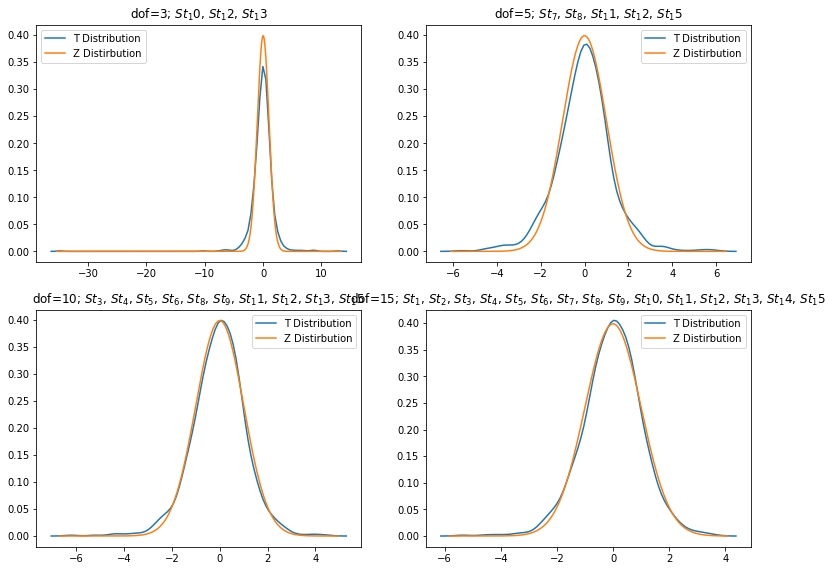

In [15]:
Z = np.random.normal(loc=0, scale=1, size=1000)

sts = [np.random.normal(loc=0, scale=1, size=1000) for _ in range(15)]
dofs = [3,5,10,15] #sorted(random.sample(range(1, len(sts) + 1), 4))

nrows = 2
ncols = 2
fig, ax = plt.subplots(nrows, ncols, figsize=(fig_size[0] * ncols, fig_size[1] * nrows))

for i, v in enumerate(dofs):
    chi_indices = random.sample(range(len(sts)), v)
    V = sim_chisquare(sts, chi_indices)
    ts = t_sample(Z, V, v)
    _ = sns.kdeplot(ts, ax=ax.flatten()[i], label="T Distribution")
    _ = sns.lineplot(np.linspace(min(ts) - 0.5, max(ts) + 0.5, num=1000), normal_pdf(np.linspace(min(ts) - 0.5, max(ts) + 0.5, num=1000), 0, 1), ax=ax.flatten()[i], label="Z Distirbution")
    _ = ax.flatten()[i].set_title(f"dof={v}; " + ", ".join([f"$St_{j + 1}$" for j in sorted(chi_indices)]))

_ = plt.legend()

# Question 3

### F Distribution
The F random variable is defined as the ratio of two adjusted chi-squared random variables.<br><br>
$f_{n_1, n_2} = \frac{\chi^2_{n_1} / n_1}{\chi^2_{n_2} / {n_2}}$; where $\chi^2_i$ is a chi squared random variable with $i$ degrees of freedom.

$f_{n_1, n_2}$ has two degrees of freedom; $n_1$ and $n_2$

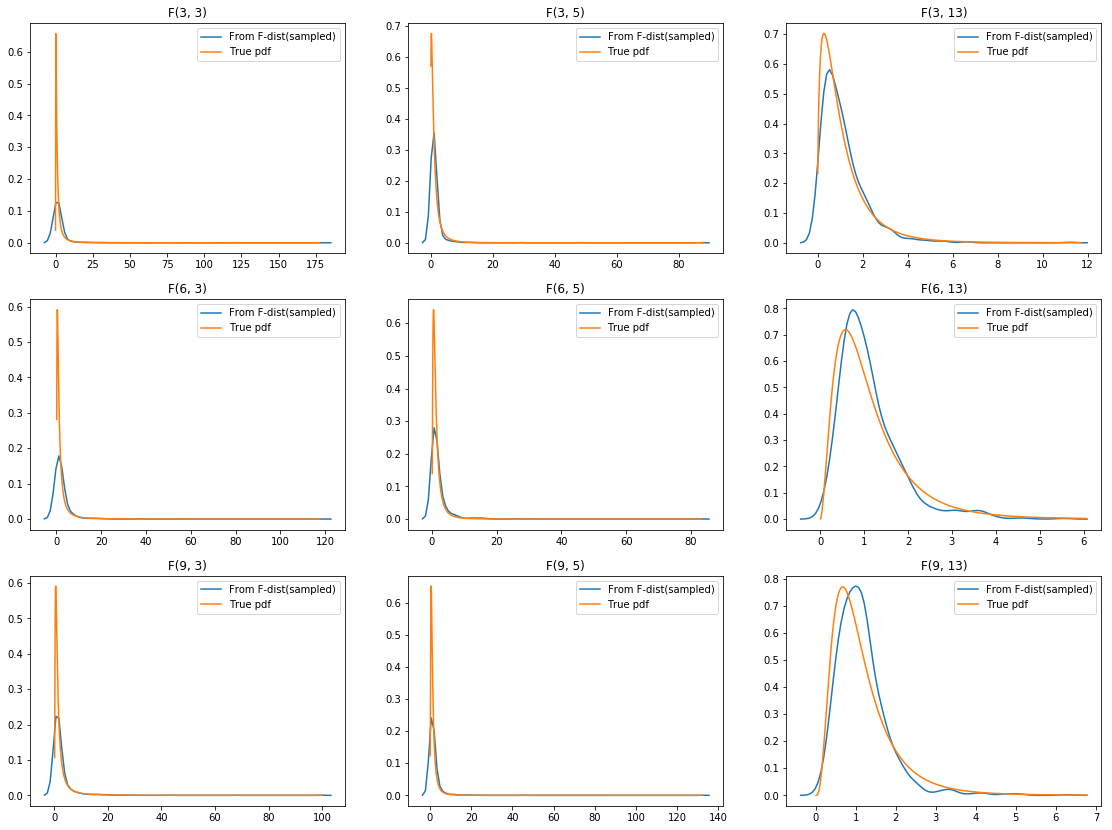

In [16]:
nume_dof = sorted(random.sample(range(1, len(sts)), 3))
denom_dof = sorted(random.sample(range(1, len(sts)), 3))

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(fig_size[0] * ncols, fig_size[1] * nrows))


for i, (u1, u2) in enumerate(product(nume_dof, denom_dof)):
    nume_chi_indices = np.random.choice(len(sts), u1)
    denom_chi_indices = np.random.choice(len(sts), u2)
    U1 = sim_chisquare(sts, nume_chi_indices)
    U2 = sim_chisquare(sts, denom_chi_indices)
    
    fs = f_sample(U1, u1, U2, u2)
    x_axis = np.linspace(max(0, min(fs) - 0.5), max(fs) + 0.5, num=1000)
    
    _ = sns.kdeplot(fs, ax=ax.flatten()[i], label='From F-dist(sampled)')
    _ = sns.lineplot(x_axis, f_pdf(x_axis, u1, u2), ax=ax.flatten()[i], label='True pdf')
    _ = ax.flatten()[i].set_title(f"F({u1}, {u2})")

# Question 4

In [17]:
def indep_to_multi(req_std, req_corr, *indeps):
    assert (req_std == req_std.T).all()
    assert (req_corr == req_corr.T).all()
    assert req_std.shape[0] == req_corr.shape[1] == len(indeps)
    
    _req_cov = np.dot(req_std, np.dot(req_corr, req_std))
    cky = cholesky(_req_cov, lower=True)
    
    return np.dot(cky, indeps)


def get_quantiles(var, num_q):
    return [sorted(var)[(len(var) * j) // num_q] for j in range(1, num_q)]


def chi_mult(x):
    mu = np.expand_dims(np.mean(x, axis=1), axis=1)
    cov = np.cov(x)

    djs = []
    for i in range(x.shape[1]):
        sam = np.expand_dims(x[:, i], axis=-1)
        y = np.matmul((sam - mu).T, np.matmul(np.linalg.inv(cov), (sam - mu)))
        djs.append(y[0][0])
    
    return djs


def get_lr_weights(X, Y):
    return np.matmul(np.matmul(np.linalg.pinv(np.matmul(X.T, X)), X.T), Y)

In [18]:
NUM_SAMPLES = 100
# reference normal samples to compare quantiles
ref_normal = np.random.normal(size=NUM_SAMPLES)

# independent normal variables
s1, s2, s3 = [np.random.normal(size=NUM_SAMPLES) for _ in range(3)]

# make into multivariate variables
req_std = np.array([
    [2, 0, 0],
    [0, 0.5, 0],
    [0, 0, 4]
])
req_corr = np.array([
    [1, 0.8, 0],
    [0.8, 1, 0],
    [0, 0, 1]
])

corr_s1, corr_s2, corr_s3 = indep_to_multi(req_std, req_corr, s1, s2, s3)

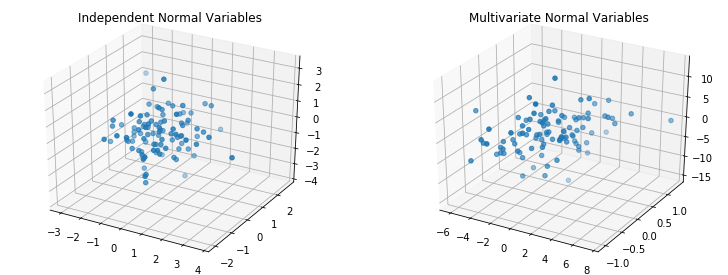

In [19]:
nrows = 1
ncols = 2
fig = plt.figure(figsize=(fig_size[0] * ncols, fig_size[1] * nrows))

ax1 = fig.add_subplot(nrows, ncols, 1, projection='3d')
_ = ax1.scatter(s1, s2, s3)
_ = ax1.set(title="Independent Normal Variables")

ax2 = fig.add_subplot(nrows, ncols, 2, projection='3d')
_ = ax2.scatter(corr_s1, corr_s2, corr_s3)
_ = ax2.set(title="Multivariate Normal Variables")

### Q-Q plots for marginal variables

To check the normality of a random variable, a Q-Q plot can be used.

The pairs $(Q_X, Q_Z)$, when plotted is a Q-Q plot. \[$Q_X$ is quantiles of X, and $Q_Z$ is quantiles of Z.\]

If X is a normal variable, then the pairs should form a (nearly)straight line with slope $\sigma_X$\[standard deviation of X\].

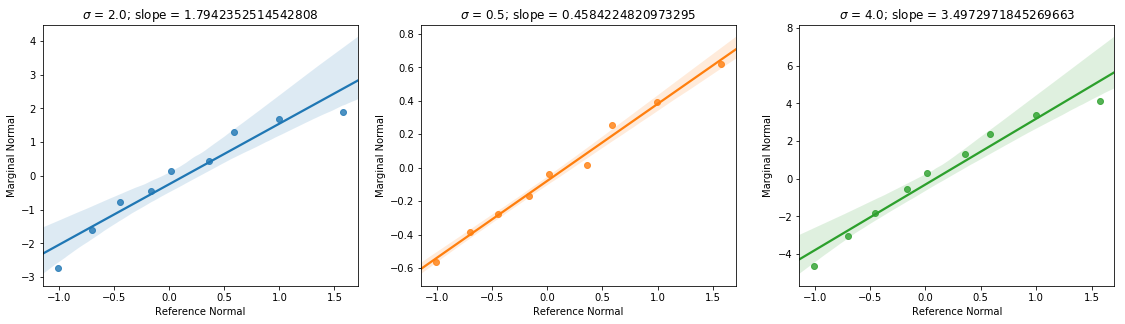

In [20]:
def get_lr_weights(X, Y):
    # account for bias
    X = np.hstack(
        (np.ones((X.shape[0], 1)), X)
    )
    return np.matmul(np.matmul(np.linalg.pinv(np.matmul(X.T, X)), X.T), Y)

num_q = 10
nrows = 1
ncols = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(fig_size[0] * ncols, fig_size[1] * nrows))

ref_quantiles = get_quantiles(ref_normal, num_q) # reference standard normal quantiles
q1 = get_quantiles(corr_s1, num_q)
q2 = get_quantiles(corr_s2, num_q)
q3 = get_quantiles(corr_s3, num_q)

lr1 = get_lr_weights(np.expand_dims(ref_quantiles, axis=1), np.expand_dims(q1, axis=-1))
lr2 = get_lr_weights(np.expand_dims(ref_quantiles, axis=1), np.expand_dims(q2, axis=-1))
lr3 = get_lr_weights(np.expand_dims(ref_quantiles, axis=1), np.expand_dims(q3, axis=-1))

_ = sns.regplot(ref_quantiles, q1, ax=ax[0])
_ = ax[0].set(xlabel="Reference Normal", ylabel="Marginal Normal", title=f"$\sigma$ = {req_std[0, 0]}; slope = {lr1[1, 0]}")
_ = sns.regplot(ref_quantiles, q2, ax=ax[1])
_ = ax[1].set(xlabel="Reference Normal", ylabel="Marginal Normal", title=f"$\sigma$ = {req_std[1, 1]}; slope = {lr2[1, 0]}")
_ = sns.regplot(ref_quantiles, q3, ax=ax[2])
_ = ax[2].set(xlabel="Reference Normal", ylabel="Marginal Normal", title=f"$\sigma$ = {req_std[2, 2]}; slope = {lr3[1, 0]}")

## Bivariate and Multivariate Normality

In the case of bivariate normal variables or any $p \geq 2$; (p is the dimensionality), the check for normality is done by using a chi squared plot.

Constructing a chi-squared plot:
1. Let $d_j = (x_j - \overline{x})^T \Sigma^{-1} (x_j - \overline{x}); 1 \leq j \leq n$; n is the number of samples and $x_j$ is a $px1$ sample vector
2. Order all the $d_j$'s from smallest to largest.
3. Graph the pairs ($q_{c, p}(\frac{j - 0.5}{n})$, $d_{(j)}^2$), where $q_{c, p}(\frac{j - 0.5}{n})$ is the $\frac{j - 0.5}{n}$ quantile of a chi-squared random variable with p degrees of freedom.

If X is a multivariate normal random vector, then the plotted pairs should form a line with slope (nearly) equal to 1.

The intuition for this method is similar to that of plotting a Q-Q plot for checking of normality of univariate variable.<br>
The variable $(x - \overline{x})^T \Sigma^{-1} (x - \overline{x})$(x is multivariate normal vector with p components) is a chi squared random variable with p degrees of freedom. The quantiles also come from a chi-squared distribution with the same number of degrees of freedom.<br>
Since they come from the same distribution, the Q-Q plot should form a straight line with slope (nearly) equal to 1.

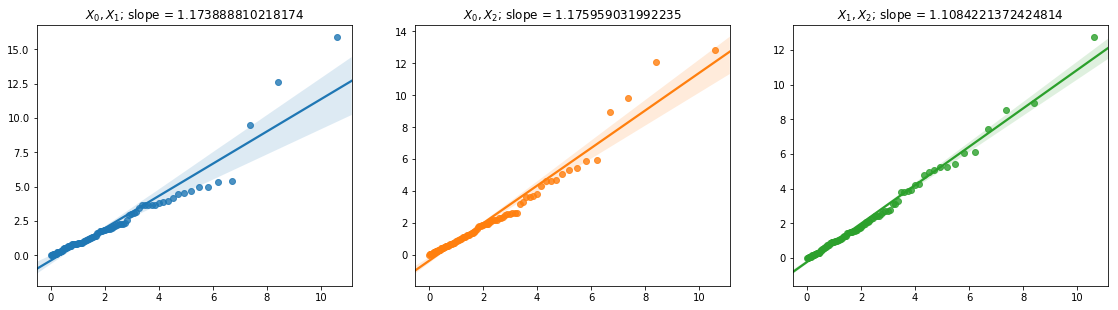

In [21]:
## Bivariate Normality

from scipy.stats import chi2

nrows = 1
ncols = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(fig_size[0] * ncols, fig_size[1] * nrows))

X = np.vstack((corr_s1, corr_s2, corr_s3))
for ax_id, (i, j) in enumerate(combinations(range(3), 2)):
    A = np.zeros((2, 3))
    A[0, i] = 1
    A[1, j] = 1
    chi_quant_ref = [chi2.isf((NUM_SAMPLES - j + 0.5) / NUM_SAMPLES, 2) for j in range(1, NUM_SAMPLES + 1)]
    djs = chi_mult(np.matmul(A, X))
    lr = get_lr_weights(np.expand_dims(chi_quant_ref, axis=-1), np.expand_dims(sorted(djs), axis=-1))
    _ = sns.regplot(chi_quant_ref, sorted(djs), ax=ax[ax_id])
    _ = ax[ax_id].set(title=f"$X_{i}, X_{j}$; slope = {lr[1, 0]}")

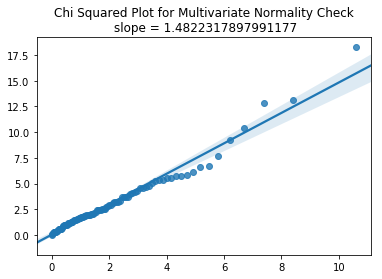

In [22]:
## Multivariate Normality

X = np.vstack((corr_s1, corr_s2, corr_s3))

chi_quant_ref = [chi2.isf((NUM_SAMPLES - j + 0.5) / NUM_SAMPLES, 2) for j in range(1, NUM_SAMPLES + 1)]  
djs = chi_mult(X)
lr = get_lr_weights(np.expand_dims(chi_quant_ref, axis=-1), np.expand_dims(sorted(djs), axis=-1))
_ = sns.regplot(chi_quant_ref, sorted(djs))
_ = _.set(title=f"Chi Squared Plot for Multivariate Normality Check\n slope = {lr[1, 0]}")